In [57]:
# Set up libraries and backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import Play, Delay, DriveChannel, ControlChannel, Waveform
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='princeton-uni-3', project='main')
backend = provider.get_backend('ibmq_rome')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# Use for conversions later
GHz = 1.0e9
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9
new_scale_factor = 1e-7

/opt/anaconda3/envs/newerQiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-05-11 08:44:14,911: Credentials are already in use. The existing account in the session will be replaced.


In [58]:
# Define for convenience
def get_closest_multiple_of_16(num):
     return int(num + 8) - (int(num + 8) % 16)

# Functions to save data to and load data from external text files
def saveData(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()
    
def loadData(file):
    filehandler = open(file)
    data = json.load(filehandler)
    filehandler.close()
    return data

# Retrieves jobs from backend and extracts IQ data
def get_job_data(job, average):
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_datas = []
    for qubit in all_qubits:
        result_data = []
        for i in range(len(job_results.results)):
            if average: # get avg data
                result_data.append(job_results.get_memory(i)[qubit]*new_scale_factor) 
            else: # get single data
                result_data.append(job_results.get_memory(i)[:, qubit]*new_scale_factor)  
        result_datas.append(result_data)
    return result_datas

In [59]:
# Projects IQ space data onto [0, 1]
def real_project(complex_data):
    real_data = np.real(complex_data)
    imag_data = np.imag(complex_data)
    m_guess = int((imag_data[-1] - imag_data[0]) / (real_data[-1] - real_data[0]))
    b_guess = int(-m_guess * real_data[0] + imag_data[0])
    lin_params, lin_fit = fit_function(real_data, imag_data, 
                                       lambda x, m, b: m*x + b, [m_guess, b_guess])
    slope, yint = lin_params
    
    rot_vals = [val * np.exp(-1j * np.arctan(slope)) for val in complex_data]
    rot_vals = np.real(rot_vals)
    rot_vals = rot_vals - np.min(rot_vals)
    max_real = np.max(rot_vals)
    rot_vals = rot_vals / np.max(rot_vals)
    if (rot_vals[-1] > rot_vals[0]):
        rot_vals = 1 - rot_vals
    return rot_vals, max_real

def cal_trig_exp(real_data, max_lim):
    real_data = 2*real_data / max_lim
    return real_data - np.mean(real_data)

# Define data fit function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

In [60]:
qubit_0 = 0
qubit_1 = 1
qubits_pref = [qubit_0, qubit_1]
all_qubits = backend_config.meas_map[0]

In [61]:
that_data = loadData('CR2Gate.txt')
cr_durs_us_gnd = that_data['cr_durs_us_gnd']
cr_durs_us_exc = that_data['cr_durs_us_exc']
cr2_durs_us_gnd = that_data['cr2_durs_us_gnd']
cr2_durs_us_exc = that_data['cr2_durs_us_exc']
cr2_durs_us_gnd = np.array(cr2_durs_us_gnd)
cr2_durs_us_exc = np.array(cr2_durs_us_exc)

cr2_job_gnd_IDs = that_data['cr2_job_gnd_IDs']
cr2_job_exc_IDs = that_data['cr2_job_exc_IDs']
gnd_exc_ID = that_data['gnd_exc_ID']
qubit_0 = that_data['qc']
qubit_1 = that_data['qt']

cr2_job_gnd_ID_x = cr2_job_gnd_IDs[0]
cr2_job_gnd_ID_y = cr2_job_gnd_IDs[1]
cr2_job_gnd_ID_z = cr2_job_gnd_IDs[2]

cr2_job_exc_ID_x = cr2_job_exc_IDs[0]
cr2_job_exc_ID_y = cr2_job_exc_IDs[1]
cr2_job_exc_ID_z = cr2_job_exc_IDs[2]

average=True

In [62]:
_, cr2_data_gnd_x, _, _, _ = get_job_data(backend.retrieve_job(cr2_job_gnd_ID_x), average)
_, cr2_data_gnd_y, _, _, _ = get_job_data(backend.retrieve_job(cr2_job_gnd_ID_y), average)
_, cr2_data_gnd_z, _, _, _ = get_job_data(backend.retrieve_job(cr2_job_gnd_ID_z), average)

cr2_real_data_gnd_x, max_real_data_gnd_x = real_project(cr2_data_gnd_x)
cr2_real_data_gnd_y, max_real_data_gnd_y = real_project(cr2_data_gnd_y)
cr2_real_data_gnd_z, max_real_data_gnd_z = real_project(cr2_data_gnd_z)

_, cr2_data_exc_x, _, _, _ = get_job_data(backend.retrieve_job(cr2_job_exc_ID_x), average)
_, cr2_data_exc_y, _, _, _ = get_job_data(backend.retrieve_job(cr2_job_exc_ID_y), average)
_, cr2_data_exc_z, _, _, _ = get_job_data(backend.retrieve_job(cr2_job_exc_ID_z), average)

cr2_real_data_exc_x, max_real_data_exc_x = real_project(cr2_data_exc_x)
cr2_real_data_exc_y, max_real_data_exc_y = real_project(cr2_data_exc_y)
cr2_real_data_exc_z, max_real_data_exc_z = real_project(cr2_data_exc_z)

_, gnd_exc_data, _, _, _ = get_job_data(backend.retrieve_job(gnd_exc_ID), average)
_, max_IQ = real_project(gnd_exc_data)

/opt/anaconda3/envs/newerQiskit/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [63]:
adj_cr2_data_gnd_x = cal_trig_exp(max_real_data_gnd_x*np.array(cr2_real_data_gnd_x), max_IQ)
adj_cr2_data_gnd_y = cal_trig_exp(max_real_data_gnd_y*np.array(cr2_real_data_gnd_y), max_IQ)
adj_cr2_data_gnd_z = cal_trig_exp(max_real_data_gnd_z*np.array(cr2_real_data_gnd_z), max_IQ)

adj_cr2_data_exc_x = cal_trig_exp(max_real_data_exc_x*np.array(cr2_real_data_exc_x), max_IQ)
adj_cr2_data_exc_y = cal_trig_exp(max_real_data_exc_y*np.array(cr2_real_data_exc_y), max_IQ)
adj_cr2_data_exc_z = cal_trig_exp(max_real_data_exc_z*np.array(cr2_real_data_exc_z), max_IQ)

In [84]:
params_gnd_x, fit_gnd_x = fit_function(cr2_durs_us_gnd, adj_cr2_data_gnd_x, 
                              lambda x, A, w, B, C: A*np.cos(w*x + B) + C,
                              [0.1, 2, 0, 0])
params_gnd_y, fit_gnd_y = fit_function(cr2_durs_us_gnd, adj_cr2_data_gnd_y, 
                              lambda x, A, w, B, C: A*np.cos(w*x + B) + C,
                              [0.1, 2, 0, 0])
params_gnd_z, fit_gnd_z = fit_function(cr2_durs_us_gnd, adj_cr2_data_gnd_z, 
                              lambda x, A, w, B, C: A*np.cos(w*x + B) + C,
                              [1, 2, 0, 0])

params_exc_x, fit_exc_x = fit_function(cr2_durs_us_exc, adj_cr2_data_exc_x, 
                              lambda x, A, w, B, C: A*np.cos(w*x + B) + C,
                              [0.1, 2, 0, 0])
params_exc_y, fit_exc_y = fit_function(cr2_durs_us_exc, adj_cr2_data_exc_y, 
                              lambda x, A, w, B, C: A*np.cos(w*x + B) + C,
                              [0.1, 2, 0, 0])
params_exc_z, fit_exc_z = fit_function(cr2_durs_us_exc, adj_cr2_data_exc_z, 
                              lambda x, A, w, B, C: A*np.cos(w*x + B) + C,
                              [1, 2, 0, 0])

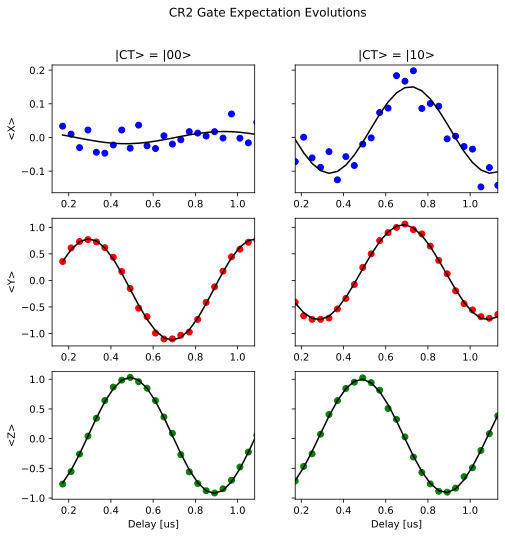

In [88]:
fig, ax = plt.subplots(3, 2, sharey='row')

ax[0][0].scatter(cr2_durs_us_gnd, adj_cr2_data_gnd_x, color='blue')
ax[0][0].plot(cr2_durs_us_gnd, fit_gnd_x, color='black')
ax[0][0].set_xlim(min(cr2_durs_us_gnd) - 0.05, max(cr2_durs_us_gnd) - 0.05)

ax[1][0].scatter(cr2_durs_us_gnd, -adj_cr2_data_gnd_y, color='red')
ax[1][0].plot(cr2_durs_us_gnd, -fit_gnd_y, color='black')
ax[1][0].set_xlim(min(cr2_durs_us_gnd) - 0.05, max(cr2_durs_us_gnd) - 0.05)

ax[2][0].scatter(cr2_durs_us_gnd, -adj_cr2_data_gnd_z, color='green')
ax[2][0].plot(cr2_durs_us_gnd, -fit_gnd_z, color='black')
ax[2][0].set_xlim(min(cr2_durs_us_gnd) - 0.05, max(cr2_durs_us_gnd) - 0.05)

ax[2][0].set_xlabel("Delay [us]")

ax[0][1].scatter(cr2_durs_us_exc, adj_cr2_data_exc_x, color='blue')
ax[0][1].plot(cr2_durs_us_exc, fit_exc_x, color='black')
ax[0][1].set_xlim(min(cr2_durs_us_exc), max(cr2_durs_us_exc))

ax[1][1].scatter(cr2_durs_us_exc, adj_cr2_data_exc_y, color='red')
ax[1][1].plot(cr2_durs_us_exc, fit_exc_y, color='black')
ax[1][1].set_xlim(min(cr2_durs_us_exc), max(cr2_durs_us_exc))

ax[2][1].scatter(cr2_durs_us_exc, -adj_cr2_data_exc_z, color='green')
ax[2][1].plot(cr2_durs_us_exc, -fit_exc_z, color='black')
ax[2][1].set_xlim(min(cr2_durs_us_exc), max(cr2_durs_us_exc))

ax[2][1].set_xlabel("Delay [us]")

ax[0][0].set_ylabel("<X>")
ax[1][0].set_ylabel("<Y>")
ax[2][0].set_ylabel("<Z>")

ax[0][0].set_title("|CT> = |00>")
ax[0][1].set_title("|CT> = |10>")

fig.set_figwidth(8)
fig.set_figheight(8)
fig.suptitle("CR2 Gate Expectation Evolutions")
plt.show()

In [96]:
_, w_gnd_z, _, _ = params_gnd_z
_, w_exc_z, _, _ = params_exc_z

print(f"Frequency in gnd state is {w_gnd_z / (2*np.pi)} MHz")
print(f"Frequency in exc state is {w_exc_z / (2*np.pi)} MHz")


Frequency in gnd state is -1.256595329584669 MHz
Frequency in exc state is -1.253816880929408 MHz
